# 1. Introduction 

Since the relationship between the tables is one of the questions that must be answered, the meaning of each of the tables must also be assumed.

Although after reading the variables and searching for their information, it can be presumed that the meaning of this table is the records of the bankruptcy processes.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 2. First look and transformations of the variables.

A quick check to see how the dataset is composed.

In [2]:
df =  pd.read_csv('Public_records.csv')
df.head()

,analytics_matchkey,industry_code_kind_of_business,reporting_subscriber_code,public_record_type_code,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number
0,1346747,ZP,99,CJ,20130604.0,20130129,NaN,1209.0,CI,I,1,NaN,NaN,NaN
1,1346748,ZP,485,7X,20140925.0,20140506,20140924.0,NaN,FE,I,1,NaN,NaN,NaN
2,1346754,Z,11R,SL,20120124.0,20110405,NaN,2248.0,RD,I,1,NaN,NaN,NaN
3,1346754,ZP,1,7X,20130129.0,20120928,20130128.0,NaN,FE,C,1,NaN,NaN,NaN
4,1346756,ZP,1,RL,20140913.0,20070202,20140801.0,406.0,RD,I,1,NaN,NaN,NaN


In [3]:
missing_data_percentage = (df.isnull().sum() / len(df)) * 100

# Create a dataframe with column names and their corresponding percentage of missing values
missing_data_df = pd.DataFrame({
    'Column Name': missing_data_percentage.index,
    'Percentage of Missing Data': missing_data_percentage.values
})


missing_data_df_sorted = missing_data_df.sort_values(by='Percentage of Missing Data', ascending=False)
missing_data_df_sorted

,Column Name,Percentage of Missing Data
11,plaintiff_name,100.000000
12,attorney_name,100.000000
13,docket_number,100.000000
6,paid_date,40.714970
7,amount,28.176892
4,effective_date_date_verified,0.130552
8,public_record_source_type_code,0.000458
0,analytics_matchkey,0.000000
1,industry_code_kind_of_business,0.000000
2,reporting_subscriber_code,0.000000


## 2.1 Analytics Matchkey 

When analyzing the column there are several repeated records, analytics_matchkey is not the primary key of the table. This may mean that there are clients who have filed for bankruptcy several times.

In [4]:
# Analytics Match Key Frequency Analysis
analytics_matchkey_counts = df['analytics_matchkey'].value_counts()
repetition_counts = analytics_matchkey_counts.value_counts().sort_index()
total_unique_keys = analytics_matchkey_counts.size

summary_all_levels = pd.DataFrame({
    'Repetition Level': repetition_counts.index,
    'Count': repetition_counts.values,
    'Percentage': (repetition_counts.values / total_unique_keys) * 100
})
summary_all_levels

,Repetition Level,Count,Percentage
0,1,90529,67.199388
1,2,25424,18.872154
2,3,9813,7.284159
3,4,4352,3.230476
4,5,2023,1.501666
5,6,1081,0.802423
6,7,605,0.449090
7,8,337,0.250154
8,9,191,0.141779
9,10,119,0.088333


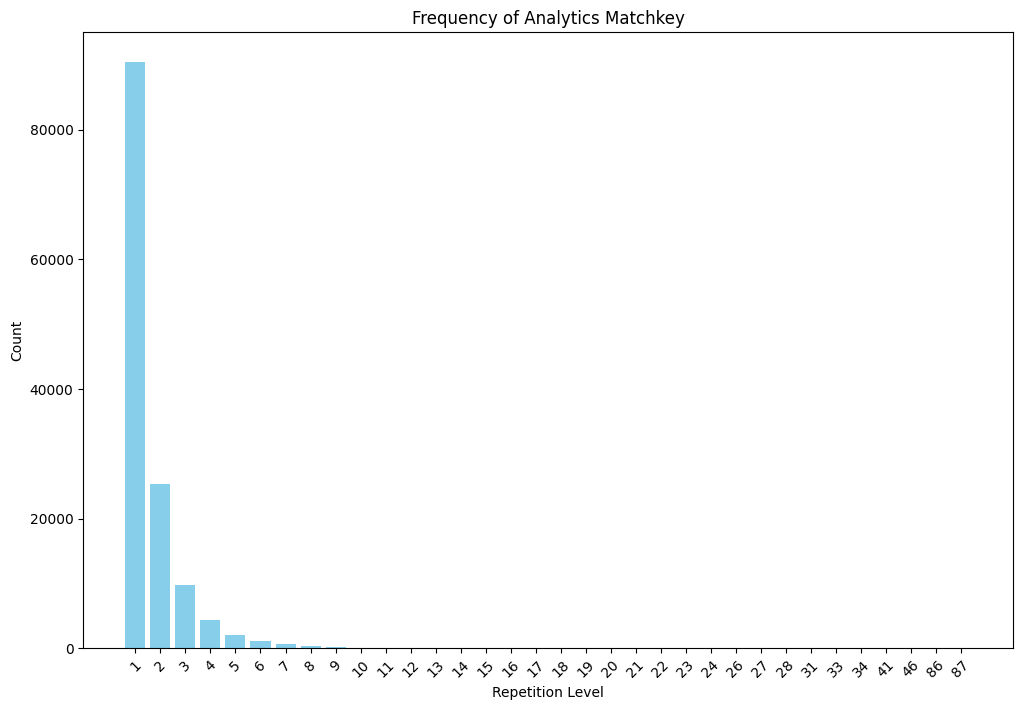

In [5]:
# Plot histogram
plt.figure(figsize=(12, 8))
plt.bar(summary_all_levels['Repetition Level'].astype(str), summary_all_levels['Count'], color='skyblue')
plt.xlabel('Repetition Level')
plt.ylabel('Count')
plt.title('Frequency of Analytics Matchkey')
plt.xticks(rotation=45)
plt.show()

That most clients have not signed more than 5 bankruptcies supports the theory that they are bankruptcy data. However, the fact that there are clients with 87 bankruptcies seems to indicate that this is not the case. Although the cases of people with more than 87 bankruptcies could be registration errors.

In the absence of a better hypothesis, we continue to accept that this table refers to bankruptcies.

## 2.2 Industry Code (Kind of Business)

The column **industry_code_kind_of_business** is analyzed. The dictionary description does not look like what is reflected in the dictionary. The dataset could be for company bankruptices but due to the small amount of the loan in "Loan_performance" table it is supposed to refer to personal bankruptcies.

One of the possible solutions to the problem of the dictionary description not matching the data shown in the column (there are only two types of data, ZP and P) would be to eliminate the column due to lack of interpretability.

Another possible solution is to add a dummy variable since the difference between ZP and Z may contain information.

Regardless of the above, both columns are studied.

In [6]:
industry_code_percentage = (df['industry_code_kind_of_business'].value_counts(normalize=True) * 1).round(4)

industry_code_summary = pd.DataFrame({
    'Count': df['industry_code_kind_of_business'].value_counts(),
    'Percentage': industry_code_percentage
})
industry_code_summary

,Count,Percentage
ZP,198571,0.9096
Z,19732,0.0904


The interpretability of the frequency is difficult in this circumstance. Perhaps by merging the tables more conclusions can be drawn.

Transformation in dummy variable. The variable is transformed into a dummy variable to be able to operate with it. 

In [7]:
df['industry_code_kind_of_business'] = df['industry_code_kind_of_business'].replace({'ZP': 1, 'Z': 0})
df.head()

,analytics_matchkey,industry_code_kind_of_business,reporting_subscriber_code,public_record_type_code,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number
0,1346747,1,99,CJ,20130604.0,20130129,NaN,1209.0,CI,I,1,NaN,NaN,NaN
1,1346748,1,485,7X,20140925.0,20140506,20140924.0,NaN,FE,I,1,NaN,NaN,NaN
2,1346754,0,11R,SL,20120124.0,20110405,NaN,2248.0,RD,I,1,NaN,NaN,NaN
3,1346754,1,1,7X,20130129.0,20120928,20130128.0,NaN,FE,C,1,NaN,NaN,NaN
4,1346756,1,1,RL,20140913.0,20070202,20140801.0,406.0,RD,I,1,NaN,NaN,NaN


## 2.3 Reporting Subscriber Code

The column **reporting_subscriber_code** is analyzed, the description does not seem to match what the column reflects. The letters are probably char type data, each one being one byte, however, at least 7 would be needed. Surely there is some transformation of the data to add information. It is discarded until more external information is discovered.

Additionally, there are repeated values, so this column does not serve as a primary key.

In [8]:
df = df.drop('reporting_subscriber_code', axis = 1)
df.head()

,analytics_matchkey,industry_code_kind_of_business,public_record_type_code,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number
0,1346747,1,CJ,20130604.0,20130129,NaN,1209.0,CI,I,1,NaN,NaN,NaN
1,1346748,1,7X,20140925.0,20140506,20140924.0,NaN,FE,I,1,NaN,NaN,NaN
2,1346754,0,SL,20120124.0,20110405,NaN,2248.0,RD,I,1,NaN,NaN,NaN
3,1346754,1,7X,20130129.0,20120928,20130128.0,NaN,FE,C,1,NaN,NaN,NaN
4,1346756,1,RL,20140913.0,20070202,20140801.0,406.0,RD,I,1,NaN,NaN,NaN


## 2.4 Public Record Type Code

This is one of the determining data to define that this table is about information on bankruptcies. That there are categories like "Child Support" seems indicative that it deals with personal and not corporate bankruptcies.

These codes seem to describe characteristics of the bankruptcy process, so they can be very useful and add information about the case. Dummy variables are created to add that information.

In [9]:
df = pd.get_dummies(df, columns=['public_record_type_code'])
df.head()

,analytics_matchkey,industry_code_kind_of_business,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,...,public_record_type_code_CJ,public_record_type_code_CP,public_record_type_code_FT,public_record_type_code_PC,public_record_type_code_PF,public_record_type_code_PL,public_record_type_code_RL,public_record_type_code_SL,public_record_type_code_TB,public_record_type_code_TL
0,1346747,1,20130604.0,20130129,NaN,1209.0,CI,I,1,NaN,...,1,0,0,0,0,0,0,0,0,0
1,1346748,1,20140925.0,20140506,20140924.0,NaN,FE,I,1,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1346754,0,20120124.0,20110405,NaN,2248.0,RD,I,1,NaN,...,0,0,0,0,0,0,0,1,0,0
3,1346754,1,20130129.0,20120928,20130128.0,NaN,FE,C,1,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1346756,1,20140913.0,20070202,20140801.0,406.0,RD,I,1,NaN,...,0,0,0,0,0,0,1,0,0,0


## 2.5 Effective Date (Date Verified) and Filed Date. 

**Filed Date:** This date is always the starting point of the bankruptcy process. It is the date on which the debtor officially files the bankruptcy petition with the court. From this moment, various legal protections and obligations begin.

**Effective Date (Date Verified):** This date generally occurs later in the process. It refers to when the provisions of a confirmed bankruptcy plan become operative.

File Date should precede the Effective Date, this is becasue the bankruptcy process needs to be officially initiated (Filed Date) before any reorganization plan can be confirmed and become effective (Effective Date). 


These columns can be used to detect problems in data collection if the order of the dates is not met. The number of days that occur between both dates may contain some type of information. Another possible source of information is the month in which the process begins due to its possible relationship with the economic cycle within the year (higher aggregate spending in December compared to a decrease in it in January, influence of summer). The author of this document hypothesizes that both data described above will have little explanatory capacity. Therefore they will not be added to this work. However, it may be a line of future research for longer projects.

In [10]:
# Convert specified columns to datetime format
date_columns = ['effective_date_date_verified', 'filed_date']
for column in date_columns:
    df[column] = pd.to_datetime(df[column], format='%Y%m%d')

df.head()

,analytics_matchkey,industry_code_kind_of_business,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,...,public_record_type_code_CJ,public_record_type_code_CP,public_record_type_code_FT,public_record_type_code_PC,public_record_type_code_PF,public_record_type_code_PL,public_record_type_code_RL,public_record_type_code_SL,public_record_type_code_TB,public_record_type_code_TL
0,1346747,1,2013-06-04,2013-01-29,NaN,1209.0,CI,I,1,NaN,...,1,0,0,0,0,0,0,0,0,0
1,1346748,1,2014-09-25,2014-05-06,20140924.0,NaN,FE,I,1,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1346754,0,2012-01-24,2011-04-05,NaN,2248.0,RD,I,1,NaN,...,0,0,0,0,0,0,0,1,0,0
3,1346754,1,2013-01-29,2012-09-28,20130128.0,NaN,FE,C,1,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1346756,1,2014-09-13,2007-02-02,20140801.0,406.0,RD,I,1,NaN,...,0,0,0,0,0,0,1,0,0,0


Check possible inconsistencies in the dataframe

In [11]:
# Calculate the number of occurrences where effective_date_date_verified occurs before filed_date
occurrences = (df['effective_date_date_verified'] < df['filed_date']).sum()

# Calculate the percentage
total_rows = len(df)
percentage = (occurrences / total_rows) * 100

occurrences, percentage

(0, 0.0)

## 2.6 Paid Date

**Paid Date** Paid Date is understood as the date on which all debts incurred or the amounts estimated by the judge to the debtors in the bankruptcy process are paid in whole or in part. There is a large percentage of empty data which will assume that nothing was paid in the trial due to the severity of the bankruptcy.

This can provide information to capture it being transformed into a dummy variable.

Another source of information is the difference in days between the start of the process and the payment, but again this will be left to future lines of research.

In [12]:
# Create a new column 'paid_date_dummy' based on 'paid_date' where NaN is 0 and any other value is 1
df['paid_date_dummy'] = df['paid_date'].apply(lambda x: 0 if pd.isna(x) else 1)
df = df.drop('paid_date', axis=1)
df.head()

,analytics_matchkey,industry_code_kind_of_business,effective_date_date_verified,filed_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,attorney_name,...,public_record_type_code_CP,public_record_type_code_FT,public_record_type_code_PC,public_record_type_code_PF,public_record_type_code_PL,public_record_type_code_RL,public_record_type_code_SL,public_record_type_code_TB,public_record_type_code_TL,paid_date_dummy
0,1346747,1,2013-06-04,2013-01-29,1209.0,CI,I,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1346748,1,2014-09-25,2014-05-06,NaN,FE,I,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2,1346754,0,2012-01-24,2011-04-05,2248.0,RD,I,1,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
3,1346754,1,2013-01-29,2012-09-28,NaN,FE,C,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
4,1346756,1,2014-09-13,2007-02-02,406.0,RD,I,1,NaN,NaN,...,0,0,0,0,0,1,0,0,0,1


## 2.7 Amount

This column has a lot of uncertainty, in the dictionary it is described as "Displays the original amount in the case." which suggests that it is the amount of unpaid debts for which the bankruptcy process is entered into.

If this variable means that, it can be expected to have a lot of explanatory power. However, there is a considerable percentage of empty spaces (28.18%).

Using statistical techniques, it is possible to infer the value of the empty spaces, however it can be dangerous due to the potential influence of the variable.

In [13]:
missing_values_count = df['amount'].isna().sum()
total_rows = df.shape[0]

missing_values_percentage = (missing_values_count / total_rows) 

missing_values_percentage

0.2817689175137309

## 2.8 Public Record Source Type Code

It can be an interesting variable. The direction of the court is influenced by the place of residence. It can provide information in the same way that zip code provides information about income or willingness to repay.

In [14]:
# Calculate the frequency of each unique value in the 'public_record_source_type_code' column
source_type_frequency = df['public_record_source_type_code'].value_counts(normalize=True) * 100


source_type_frequency_dict = source_type_frequency.to_dict()
source_type_frequency_dict

{'CI': 44.637703731527886,
 'FE': 26.979138990939155,
 'RD': 25.03733360207419,
 'MU': 1.507544594186036,
 'BK': 1.1960495093952415,
 'SU': 0.22262736942400893,
 'CC': 0.1003197405429176,
 'CR': 0.08932579637383076,
 'SC': 0.0746672041483816,
 'DC': 0.06687982702861174,
 'JU': 0.024278293373400154,
 'CT': 0.022904050352264296,
 'MA': 0.019239402295902007,
 'CL': 0.011910106183177433,
 'CY': 0.005038891077498144,
 'CP': 0.0027484860422717153,
 'CA': 0.0009161620140905718,
 'CN': 0.0004580810070452859,
 'AS': 0.0004580810070452859,
 'PC': 0.0004580810070452859}

The most frequent element is the CI so we will use that element to fill all the empty spaces.

In [15]:
if 'public_record_source_verified' in df.columns:
    df['public_record_source_verified'].fillna('CI', inplace=True)

Almost all cases are heard in a few courts. It is possible add dummy variables.

In [16]:
df = pd.get_dummies(df, columns=['public_record_source_type_code'])
df.head()

,analytics_matchkey,industry_code_kind_of_business,effective_date_date_verified,filed_date,amount,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number,...,public_record_source_type_code_CY,public_record_source_type_code_DC,public_record_source_type_code_FE,public_record_source_type_code_JU,public_record_source_type_code_MA,public_record_source_type_code_MU,public_record_source_type_code_PC,public_record_source_type_code_RD,public_record_source_type_code_SC,public_record_source_type_code_SU
0,1346747,1,2013-06-04,2013-01-29,1209.0,I,1,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1346748,1,2014-09-25,2014-05-06,NaN,I,1,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,1346754,0,2012-01-24,2011-04-05,2248.0,I,1,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,1346754,1,2013-01-29,2012-09-28,NaN,C,1,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,1346756,1,2014-09-13,2007-02-02,406.0,I,1,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0


## 2.9 Equal Credit Opportunity Act Code

The Equal Credit Opportunity Act (ECOA) is a federal law in the United States that prohibits creditors from discriminating against credit applicants. The law aims to ensure that everyone has a fair chance to obtain credit. During the bankruptcy process, all of the debtor's credit reports are reviewed to create a clear picture of their financial obligations. The ECOA Code helps to:

**Determine Joint Properties and Debts:** Identify which debts and properties are shared with other individuals, which is essential for the correct distribution of liabilities.

**Evaluate Eligibility:** Help determine the debtor's eligibility for certain chapters of bankruptcy, such as Chapter 7 (liquidation) or Chapter 13 (reorganization).

In [17]:
# Calculate the frequency of each unique value in the 'public_record_source_type_code' column
source_type_frequency = df['equal_credit_opportunity_act_code'].value_counts(normalize=True) * 100


source_type_frequency_dict = source_type_frequency.to_dict()
source_type_frequency_dict

{'I': 71.47267788349221, 'C': 28.52732211650779}

The "I" ECOA code stands for an individual account. This means that the account is held solely by one person, and this individual is fully responsible for the debt or credit line associated with that account.

The "C" ECOA code stands for a co-signer or co-borrower account. This indicates that the person has signed on to share the responsibility for repaying a debt, typically because the primary borrower needed additional support to secure the credit.

A priori this variable will have a great capacity for explanation. Co-signers will probably be less responsible for the bankruptcy process and will be more willing to repay debts.

In [18]:
df['equal_credit_opportunity_act_code'] = df['equal_credit_opportunity_act_code'].replace({'I': 1, 'C': 0})
df.head()

,analytics_matchkey,industry_code_kind_of_business,effective_date_date_verified,filed_date,amount,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number,...,public_record_source_type_code_CY,public_record_source_type_code_DC,public_record_source_type_code_FE,public_record_source_type_code_JU,public_record_source_type_code_MA,public_record_source_type_code_MU,public_record_source_type_code_PC,public_record_source_type_code_RD,public_record_source_type_code_SC,public_record_source_type_code_SU
0,1346747,1,2013-06-04,2013-01-29,1209.0,1,1,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1346748,1,2014-09-25,2014-05-06,NaN,1,1,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,1346754,0,2012-01-24,2011-04-05,2248.0,1,1,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,1346754,1,2013-01-29,2012-09-28,NaN,0,1,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,1346756,1,2014-09-13,2007-02-02,406.0,1,1,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0


## 2.10 Legislative Prohibited Code

Accounts identified with a "Legislative Prohibited Code" may be subject to specific protections that prevent certain funds from being used to pay debts in a bankruptcy proceeding.

In [19]:
source_type_frequency = df['legislative_prohibited_code'].value_counts(normalize=True) 
source_type_frequency_dict = source_type_frequency.to_dict()
source_type_frequency_dict

{1: 0.9294833327989079, 2: 0.07051666720109206}

In [20]:
df['legislative_prohibited_code'] = df['legislative_prohibited_code'] -1
df.head()

,analytics_matchkey,industry_code_kind_of_business,effective_date_date_verified,filed_date,amount,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number,...,public_record_source_type_code_CY,public_record_source_type_code_DC,public_record_source_type_code_FE,public_record_source_type_code_JU,public_record_source_type_code_MA,public_record_source_type_code_MU,public_record_source_type_code_PC,public_record_source_type_code_RD,public_record_source_type_code_SC,public_record_source_type_code_SU
0,1346747,1,2013-06-04,2013-01-29,1209.0,1,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1346748,1,2014-09-25,2014-05-06,NaN,1,0,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,1346754,0,2012-01-24,2011-04-05,2248.0,1,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,1346754,1,2013-01-29,2012-09-28,NaN,0,0,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,1346756,1,2014-09-13,2007-02-02,406.0,1,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0


Probably relevant in the collections list.

## 2.11 Plaintiff Name, Attorney Name, Docket Number

In [21]:
df.drop(columns=['plaintiff_name', 'attorney_name', 'docket_number'], inplace=True, errors='ignore')
df.head()

,analytics_matchkey,industry_code_kind_of_business,effective_date_date_verified,filed_date,amount,equal_credit_opportunity_act_code,legislative_prohibited_code,public_record_type_code_1D,public_record_type_code_1F,public_record_type_code_1X,...,public_record_source_type_code_CY,public_record_source_type_code_DC,public_record_source_type_code_FE,public_record_source_type_code_JU,public_record_source_type_code_MA,public_record_source_type_code_MU,public_record_source_type_code_PC,public_record_source_type_code_RD,public_record_source_type_code_SC,public_record_source_type_code_SU
0,1346747,1,2013-06-04,2013-01-29,1209.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1346748,1,2014-09-25,2014-05-06,NaN,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1346754,0,2012-01-24,2011-04-05,2248.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1346754,1,2013-01-29,2012-09-28,NaN,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1346756,1,2014-09-13,2007-02-02,406.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# 3. Primary Key 

In order to have more interpretability about what the table is and the tuples that make up one of the main sources of information is the Primary Key. It has been seen in the previous point that **analytics_matchkey** does not form a primary key since there is repetition. Thanks to this, the theory that each tuple represents a client who has declared bankruptcy can be ruled out.

## 3.1 Primary Key as One Bankruptcy

It is hypothesized that each tuple represents the file of a delcara bankruptcy, so an **analytics_matchkey** client could have signed more than one throughout its life. Therefore the _Primary Key_ should be the union of the bankruptcy date **filed_date** and the person filing it. (Assuming a person can only file one bankruptcy per day.)

In [22]:
df3 = pd.read_csv('Public_records.csv')
is_unique = not df3.duplicated(subset=['analytics_matchkey', 'filed_date']).any()

is_unique

False

The theory must be discarded. 

## 3.2 Primary Key as Person

It is hypothesized that each tuple represents a person in the bankruptcy process, as seen **equal_credit_opportunity_act_code** represents that the person and the mode that appears in the bankruptcy files is the individual responsible for it or has signed on to share the responsibility.

Then the primary key would be **analytics_matchkey** representing a person or case, **equal_credit_opportunity_act_code** representing the person and **filed_date** making the bankruptcy process unique.

In [23]:
is_unique = not df3.duplicated(subset=['analytics_matchkey', 'equal_credit_opportunity_act_code']).any()
is_unique

False

The theory must be discarded.

## 3.3 Primary Key as Docuemnt 

It is hypothesized that each tuple represents the sending of a document or its officiality regarding a bankruptcy process. For this, the bankruptcy process would be given by the person and their relationship with the bankruptcy (**analytics_matchkey**, **equal_credit_opportunity_act_code**), the date on which the bankruptcy is declared (**filed_date**) and the type document and where it comes from (**public_record_type_code**, **public_record_source_type_code**)

In [24]:
is_unique = not df3.duplicated(subset=['analytics_matchkey', 'equal_credit_opportunity_act_code','filed_date','public_record_type_code','public_record_source_type_code']).any()
is_unique

False

The theory must be discarded

## 3.4 Primary key as Payment 

One could assume that each tuple represents a monetary transaction. **paid_date** and **amount**. Every time a transaction referring to a trial is made, a tuple is created.

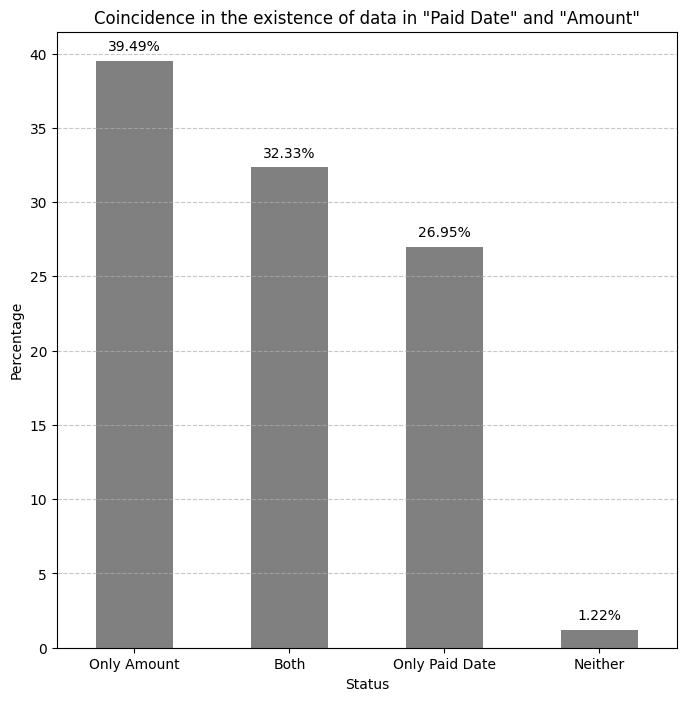

In [25]:
# Creating a new column to categorize the entries based on the presence of data in 'paid_date' and 'amount'
df3['status'] = df3.apply(
    lambda row: 'Both' if pd.notnull(row['paid_date']) and pd.notnull(row['amount'])
    else 'Only Paid Date' if pd.notnull(row['paid_date']) and pd.isnull(row['amount'])
    else 'Only Amount' if pd.isnull(row['paid_date']) and pd.notnull(row['amount'])
    else 'Neither',
    axis=1
)

confusion_matrix = df3['status'].value_counts(normalize=True) * 100

confusion_matrix.plot(kind='bar', color=['grey', 'grey', 'grey', 'grey'], figsize=(8, 8))


plt.xlabel('Status')
plt.ylabel('Percentage')
plt.title('Coincidence in the existence of data in "Paid Date" and "Amount"')


for index, value in enumerate(confusion_matrix):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The fact that there is only a 30% coincidence of data greatly weakens the strength of this theory. It doesn't make much sense that, being a payment record, the most important data such as the amount and date have so many empty records.

However, in the absence of a better hypothesis we will take this one as the valid one.

# 4. Study, hypothesis and transformation

In this section, ideas and institutions are developed that have been obtained by doing a first analysis of the data. An attempt will be made to extract implicit metadata from the dataset.

## 4.1 Analytics Matchkey and Multiple Bankruptcies.

It is hypothesized that **analytics_matchkey** refers to a person. If a person declares more than one bankruptcy in their life, it is a relevant fact. That a person has had multiple bankruptcies throughout his life makes one think that he is not a safe client and that he will have even more in the future. So this information is going to be captured.

In [26]:
# Add a column 'number_bankruptcies' with the number of unique filed_dates for each analytics_matchkey
df['number_bankruptcies'] = df.groupby('analytics_matchkey')['filed_date'].transform('nunique')
df.head()

,analytics_matchkey,industry_code_kind_of_business,effective_date_date_verified,filed_date,amount,equal_credit_opportunity_act_code,legislative_prohibited_code,public_record_type_code_1D,public_record_type_code_1F,public_record_type_code_1X,...,public_record_source_type_code_DC,public_record_source_type_code_FE,public_record_source_type_code_JU,public_record_source_type_code_MA,public_record_source_type_code_MU,public_record_source_type_code_PC,public_record_source_type_code_RD,public_record_source_type_code_SC,public_record_source_type_code_SU,number_bankruptcies
0,1346747,1,2013-06-04,2013-01-29,1209.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1346748,1,2014-09-25,2014-05-06,NaN,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1346754,0,2012-01-24,2011-04-05,2248.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
3,1346754,1,2013-01-29,2012-09-28,NaN,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
4,1346756,1,2014-09-13,2007-02-02,406.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2


A graph to see results:

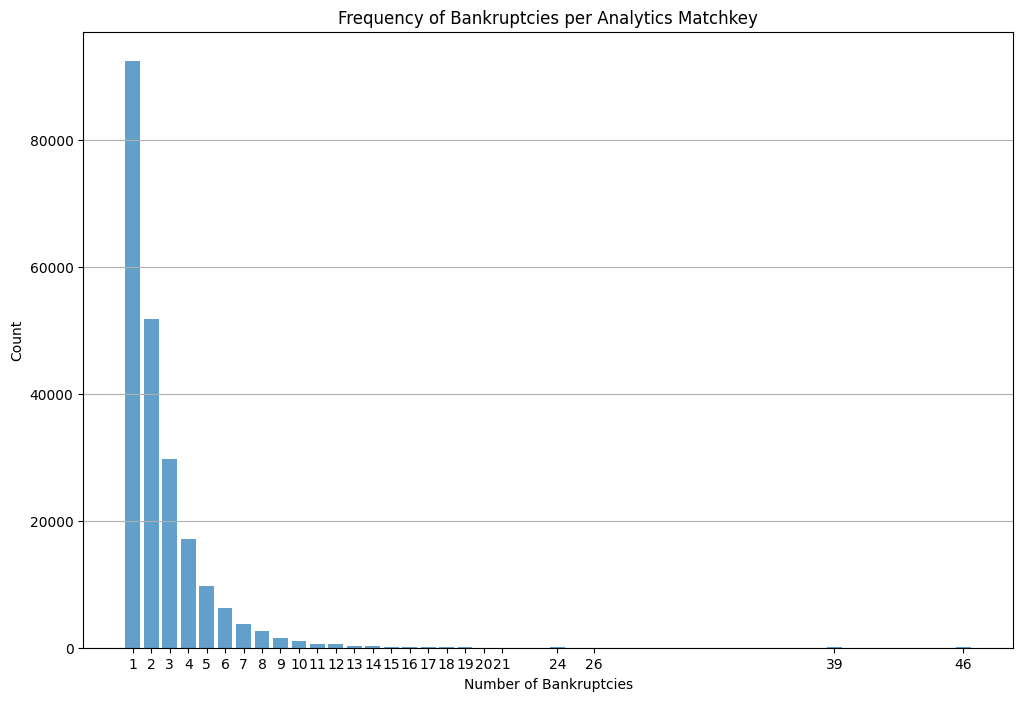

In [27]:
bankruptcy_counts = df['number_bankruptcies'].value_counts().sort_index()

# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(bankruptcy_counts.index, bankruptcy_counts.values, alpha=0.7)
plt.xlabel('Number of Bankruptcies')
plt.ylabel('Count')
plt.title('Frequency of Bankruptcies per Analytics Matchkey')
plt.xticks(bankruptcy_counts.index)
plt.grid(axis='y')

plt.show()

The fact that there are people with more than 10 bankruptcies sounds strange. These particular cases should be studied to find out if it is due to a problem with data collection (inconsistent data) and delete it. The scope of this project is smaller due to time constraints.

## 4.2 Study of Amount

Two possibilities arise: that the empty Amount spaces are due to the fact that there is no payment for that tuple, that the record has been lost or make it private in certain reports.

In [28]:
df_amount = df.copy()
df_amount['amount'] = df_amount['amount'].fillna(0)
df_amount['amount'] = df_amount['amount'].apply(lambda x: 1 if x != 0 else 0)
df_amount['amount'] = df_amount['amount'].apply(lambda x: 1 if x != 0 else 0)
correlations_updated = df_amount.corr()

# Sort correlations by absolute value to find the most significant correlations with 'amount'
correlation_with_amount_updated = correlations_updated['amount'].abs().sort_values(ascending=False)
correlation_with_amount_updated

C:\Users\Cash\AppData\Local\Temp\ipykernel_18364\836172753.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations_updated = df_amount.corr()


amount                               1.000000
public_record_source_type_code_FE    0.962011
public_record_type_code_7X           0.860872
public_record_source_type_code_CI    0.554658
paid_date_dummy                      0.465205
public_record_type_code_CJ           0.395367
public_record_source_type_code_RD    0.361668
public_record_type_code_PC           0.237692
number_bankruptcies                  0.233038
public_record_type_code_3D           0.225830
public_record_type_code_3X           0.202025
public_record_type_code_RL           0.199732
industry_code_kind_of_business       0.198433
equal_credit_opportunity_act_code    0.184948
public_record_type_code_SL           0.174700
public_record_source_type_code_BK    0.174131
legislative_prohibited_code          0.174034
public_record_type_code_3F           0.159100
public_record_type_code_CB           0.140359
public_record_type_code_7D           0.113092
public_record_type_code_FT           0.110784
public_record_type_code_PL        

There is a very large correlation (0.962) between the publication of the Amount data and the file coming from the Federal District, this may mean that they are the only ones that publish data while the rest do not.

In this way we can try to estimate the Amount not published in the rest of the institutions. To do the interpolation, the dates will be ignored and the payments will belong to the same "analytics_mathkey", the latter should be very relevant, but due to the scope of the project it will be simplified.

In [29]:
excluded_columns = ['analytics_matchkey', 'effective_date_date_verified', 'filed_date']
df.set_index(excluded_columns, inplace=True)
df['amount'] = df['amount'].interpolate(method='linear')
df.reset_index(inplace=True)

df.head()


,analytics_matchkey,effective_date_date_verified,filed_date,industry_code_kind_of_business,amount,equal_credit_opportunity_act_code,legislative_prohibited_code,public_record_type_code_1D,public_record_type_code_1F,public_record_type_code_1X,...,public_record_source_type_code_DC,public_record_source_type_code_FE,public_record_source_type_code_JU,public_record_source_type_code_MA,public_record_source_type_code_MU,public_record_source_type_code_PC,public_record_source_type_code_RD,public_record_source_type_code_SC,public_record_source_type_code_SU,number_bankruptcies
0,1346747,2013-06-04,2013-01-29,1,1209.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1346748,2014-09-25,2014-05-06,1,1728.5,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1346754,2012-01-24,2011-04-05,0,2248.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
3,1346754,2013-01-29,2012-09-28,1,1327.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
4,1346756,2014-09-13,2007-02-02,1,406.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2


# 5. Preparation for the merge

To do the merge with the other table you must make it unique
analytics_matchkey, to do this the one with the last date (most recent bankruptcy) will be chosen. This does not solve the problem, since there are tuples with the same date. To solve which one to choose then it will be done randomly. This decision is a bad decision since there is surely some better criterion, however, due to the scope of the project it will be done this way. That it is a random decision should not increase the systematic error, the least bad option.

In [30]:
# Step 1: Group by 'analytics_matchkey' and 'filed_date', and count occurrences
df_grouped = df.groupby(['analytics_matchkey', 'filed_date']).size().reset_index(name='count')

# Step 2: Filter groups that have more than one occurrence (same key and date)
duplicate_keys = df_grouped[df_grouped['count'] > 1]['analytics_matchkey'].unique()

# Step 3: Filter out rows where 'analytics_matchkey' is in duplicate_keys and keep the most recent entry
df_cleaned = df[~((df['analytics_matchkey'].isin(duplicate_keys)) & (df['filed_date'] != df.groupby('analytics_matchkey')['filed_date'].transform('max')))]

df = df_cleaned

In [31]:
# Create a copy of the original dataframe to perform the operations
df_unique = df_cleaned.copy()

# Identify rows that have duplicates in 'analytics_matchkey'
duplicated_keys = df_unique[df_unique.duplicated(subset=['analytics_matchkey'], keep=False)]['analytics_matchkey'].unique()

# Create a dictionary to store randomly selected unique rows
unique_entries = {}

# Iterate through the duplicate keys and select a random row for each
for key in duplicated_keys:
    rows = df_unique[df_unique['analytics_matchkey'] == key]
    random_index = random.choice(rows.index)
    unique_entries[key] = random_index

# Create a list of indices to keep (randomly selected) and remove the others
indices_to_keep = list(unique_entries.values())
df_unique = df_unique[df_unique.index.isin(indices_to_keep)]

# Combine with the rows that were already unique
df_unique = pd.concat([df_unique, df_cleaned[~df_cleaned['analytics_matchkey'].isin(duplicated_keys)]])

# Ensure there are no duplicates
df_unique.drop_duplicates(subset=['analytics_matchkey'], inplace=True)

df = df_unique
df.head()


,analytics_matchkey,effective_date_date_verified,filed_date,industry_code_kind_of_business,amount,equal_credit_opportunity_act_code,legislative_prohibited_code,public_record_type_code_1D,public_record_type_code_1F,public_record_type_code_1X,...,public_record_source_type_code_DC,public_record_source_type_code_FE,public_record_source_type_code_JU,public_record_source_type_code_MA,public_record_source_type_code_MU,public_record_source_type_code_PC,public_record_source_type_code_RD,public_record_source_type_code_SC,public_record_source_type_code_SU,number_bankruptcies
3,1346754,2013-01-29,2012-09-28,1,1327.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
5,1346756,2014-09-13,2008-03-12,1,925.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
10,1346767,2010-08-07,2009-12-02,1,2830.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
13,1346784,2012-05-03,2011-08-16,1,368.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
16,1346816,2015-09-01,2015-05-13,1,4210.0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2


Finally, before saving it, the date columns are eliminated.

In [32]:
df = df.drop(columns=['effective_date_date_verified', 'filed_date'])
df.head()

,analytics_matchkey,industry_code_kind_of_business,amount,equal_credit_opportunity_act_code,legislative_prohibited_code,public_record_type_code_1D,public_record_type_code_1F,public_record_type_code_1X,public_record_type_code_2D,public_record_type_code_2F,...,public_record_source_type_code_DC,public_record_source_type_code_FE,public_record_source_type_code_JU,public_record_source_type_code_MA,public_record_source_type_code_MU,public_record_source_type_code_PC,public_record_source_type_code_RD,public_record_source_type_code_SC,public_record_source_type_code_SU,number_bankruptcies
3,1346754,1,1327.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
5,1346756,1,925.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
10,1346767,1,2830.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
13,1346784,1,368.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
16,1346816,1,4210.0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2


Save the file 

In [33]:
df.to_csv('Public_records_transformed.csv', index=False)
df.head()

,analytics_matchkey,industry_code_kind_of_business,amount,equal_credit_opportunity_act_code,legislative_prohibited_code,public_record_type_code_1D,public_record_type_code_1F,public_record_type_code_1X,public_record_type_code_2D,public_record_type_code_2F,...,public_record_source_type_code_DC,public_record_source_type_code_FE,public_record_source_type_code_JU,public_record_source_type_code_MA,public_record_source_type_code_MU,public_record_source_type_code_PC,public_record_source_type_code_RD,public_record_source_type_code_SC,public_record_source_type_code_SU,number_bankruptcies
3,1346754,1,1327.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
5,1346756,1,925.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
10,1346767,1,2830.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
13,1346784,1,368.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
16,1346816,1,4210.0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
